# Preprocessing

## Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from joblib import dump, load

In [2]:
file_path = "C:/Users/user/Documents/Capstone Analisis Sentimen/Dataset/dataset_komentar_instagram_cyberbullying.csv"
df = pd.read_csv(file_path)
df.rename(columns={'Instagram Comment Text' : 'ArtScape Comment Text'}, inplace=True)

In [3]:
df.head()

,Id,Sentiment,ArtScape Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


#### Label Encoding

Membuat dataset yang bersifat kategoris 

*0 = negative*
*1 = positive*

In [4]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'].values)
df

,Id,Sentiment,ArtScape Comment Text
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...


*Menampilkan Informasi tentang DataFrame*

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     400 non-null    int64 
 1   Sentiment              400 non-null    int32 
 2   ArtScape Comment Text  400 non-null    object
dtypes: int32(1), int64(1), object(1)
memory usage: 7.9+ KB


*Menampilkan daftar nama kolom dalam DataFrame*

In [6]:
df.columns

Index(['Id', 'Sentiment', 'ArtScape Comment Text'], dtype='object')

*Mencetak total jumlah komentar dengan pesan yang sesuai dan Mencetak jumlah komentar dengan sentimen positif dan sentimen negatif beserta pesannya*

In [7]:
print('Total Sentiment Comment ArtScape:', df.shape[0], 'df\n')
print('terdiri dari (Sentiment):')
print('[0] Sentiment positive\t:', df[df.Sentiment == 1].shape[0], 'data\n')
print('[1] Sentiment Negative\t:', df[df.Sentiment == 0].shape[0], 'data\n')

Total Sentiment Comment ArtScape: 400 df

terdiri dari (Sentiment):
[0] Sentiment positive	: 200 data

[1] Sentiment Negative	: 200 data



### Distributor Kategori Sentiment ###

*visualisasi distribusi kategori sentimen dalam DataFrame*

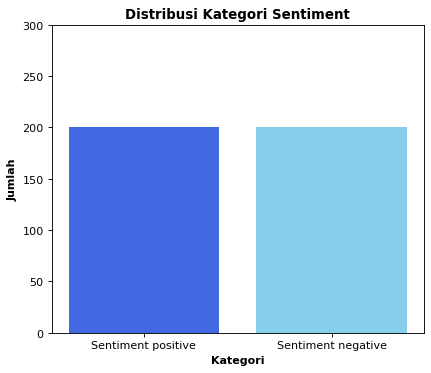

In [8]:
height = df['Sentiment'].value_counts()
labels = ('Sentiment positive', 'Sentiment negative')
y_pos = np.arange(len(labels))

plt.figure(figsize=(6, 5), dpi=(80))
plt.ylim(0, 300)
plt.title('Distribusi Kategori Sentiment', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# Text Preprocessing

## Case Folding

*lakukan beberapa langkah pemrosesan teks, termasuk case folding (mengubah semua huruf menjadi huruf kecil) dan penghapusan pola teks tertentu seperti nama pengguna Twitter, hashtag, URL, tag HTML, dan karakter non-alfabet*

In [9]:
def casefolding(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text

*ambil sampel data dari kolom 'ArtScape Comment Text' pada DataFrame df, kemudian melakukan case folding menggunakan fungsi casefolding yang telah didefinisikan sebelumnya, dan akhirnya mencetak hasilnya*

In [10]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)

print('Raw df\t:', raw_sample)
print('Case folding\t:', case_folding)

Raw df	:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun


## Word Normalization

*membaca file CSV yang berisi data kunci yang telah dinormalisasi, kemudian mencetak beberapa baris pertama dari data tersebut dan mengembalikan dimensi DataFrame*

In [11]:
file_path = "C:/Users/user/Documents/Capstone Analisis Sentimen/Dataset/key_norm.csv"
key_norm = pd.read_csv(file_path)
print(key_norm.head())
key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3721, 3)

*lakukan normalisasi teks dengan menggunakan data kunci yang telah dibaca sebelumnya*

In [12]:
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()]) 
    text = str.lower(text)
    return text

## Filtering (Stopword Removal)

*mengambil daftar kata-kata stopwords dalam bahasa Indonesia dari modul stopwords dalam NLTK (Natural Language Toolkit), kemudian menambahkan beberapa kata tambahan ke dalam daftar tersebut*

In [13]:
stopwords_ind = stopwords.words('indonesian')
more_stopword = ['tsel', 'gb', 'rb']
stopwords_ind = stopwords_ind + more_stopword

*hapus kata-kata stopwords dari teks yang diberikan*

In [14]:
def remove_stop_words(text):
    return " ".join([word for word in text.split() if word not in stopwords_ind])

*ambil contoh teks dari kolom 'ArtScape Comment Text' dalam DataFrame df, kemudian melakukan beberapa tahapan pemrosesan teks seperti case folding, normalisasi teks, dan penghapusan kata-kata stopwords, serta mencetak hasilnya*

In [15]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)  
stopword_removal = remove_stop_words(normalized_text) 

print('Raw df\t\t:', raw_sample)
print('Case folding\t:', case_folding)
print('Stopword Removal\t:', stopword_removal)

Raw df		:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun
Stopword Removal	: ahhh jaga ucapan lahh ucapan dijaga dasar munafik dasar betina zaman ellu kali yangg kelebihan micin otak selangkangan paham semoga tuhan ampunin kemunafikan cun


## Steaming

*gunakan pustaka Sastrawi untuk membuat objek stemmer, yang akan digunakan untuk melakukan stemming pada kata-kata dalam bahasa Indonesia*

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

*lakukan stemming pada teks yang diberikan menggunakan objek stemmer yang telah dibuat sebelumnya*

In [17]:
def stemming(text):
    return stemmer.stem(text)

*lakukan beberapa tahapan pemrosesan teks secara berurutan, termasuk case folding, normalisasi kata, penghapusan kata-kata stopwords, dan stemming*

In [18]:
def text_preprocessing_process(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stop_words(text)
    text = stemming(text)
    return text

*lakukan pra-pemrosesan teks pada satu contoh teks yang diambil dari kolom 'ArtScape Comment Text' dalam DataFrame, meliputi langkah-langkah case folding, normalisasi teks, penghapusan kata-kata stopwords, dan stemming, serta mencetak hasilnya untuk memeriksa perubahan yang terjadi pada teks setelah melalui setiap tahapan.*

In [19]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)  
stopword_removal = remove_stop_words(normalized_text) 
text_stemming = stemming(stopword_removal)

print('Raw df\t\t:', raw_sample)
print('Case folding\t:', case_folding)
print('Stopword Removal\t:', stopword_removal)
print('Stemming\t\t:', text_stemming)

Raw df		:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun
Stopword Removal	: ahhh jaga ucapan lahh ucapan dijaga dasar munafik dasar betina zaman ellu kali yangg kelebihan micin otak selangkangan paham semoga tuhan ampunin kemunafikan cun
Stemming		: ahhh jaga ucap lahh ucap jaga dasar munafik dasar betina zaman ellu kali yangg lebih micin otak selangkang paham moga tuhan ampunin munafik cun


# Text Preprocessing Pipeline
#### Pipeline ini bertujuan untuk membersihkan dan menormalkan teks sehingga lebih cocok untuk analisis dan pemrosesan oleh model atau algoritma.

*mengukur waktu eksekusi dan menerapkan fungsi text_preprocessing_process pada setiap baris teks dalam kolom 'ArtScape Comment Text' dari DataFrame, dengan tujuan untuk melakukan pra-pemrosesan teks pada data tersebut dan menyimpan hasilnya dalam kolom baru 'clean_teks'.*

In [20]:
%%time
df['clean_teks'] = df['ArtScape Comment Text'].apply(text_preprocessing_process)

CPU times: total: 1min 49s
Wall time: 4min 15s


*menampilkan DataFrame*

In [21]:
df

,Id,Sentiment,ArtScape Comment Text,clean_teks
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol hubung nya gugur pakai hijab syar bilang...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tatacowo banget bain balikanhadewwntar t...
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek skr lengket duhhh labil banget s...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att nya anak kasihan kembang psikis...
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,asli cantik ayu loh mbak temu langsung sembak ...


*menyimpannya ke dalam file CSV yang disebut 'clean_data.csv'*

In [22]:
df.to_csv('clean_data_baru.csv')

# Feature Engineering

*menyiapkan data untuk proses feature engineering. Variabel x berisi teks yang telah dibersihkan dari DataFrame df, sedangkan variabel y berisi label sentimen yang sesuai dengan teks tersebut*

In [23]:
x = df['clean_teks']
y = df['Sentiment']

*menampilkan variabel 'x' yang berisi teks yang telah dibersihkan*

In [24]:
x

0      tolol hubung nya gugur pakai hijab syar bilang...
1      bodoh tatacowo banget bain balikanhadewwntar t...
2      kemarin mewek skr lengket duhhh labil banget s...
3      inti kesel att nya anak kasihan kembang psikis...
4      hadewwwww permpuan lgsakit jiwaknp peran utama...
                             ...                        
395    bangga suami istri sela apa profesi kau juara ...
396      apaoun kerja halal tuk nafkah keluarga semangat
397    gojek mayoritas pegangguran kerja putus asaa t...
398    asli cantik ayu loh mbak temu langsung sembak ...
399    suami umur mbak tua alhamdulillah suami kekana...
Name: clean_teks, Length: 400, dtype: object

*menampilkan variabel 'y' yang berisi label sentimen yang sesuai*

In [25]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: Sentiment, Length: 400, dtype: int32

## Feature Extraction (TF-IDF and N-Gram)

*gunakan metode TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah teks yang telah dibersihkan dalam variabel x menjadi representasi matriks TF-IDF*

In [26]:
tf_idf = TfidfVectorizer(ngram_range=(1, 1))
x_tf_idf = tf_idf.fit_transform(x).toarray()

*cetak jumlah total fitur (kata-kata) yang telah diekstraksi dari teks menggunakan TF-IDF, serta daftar fitur tersebut*

In [27]:
print(len(tf_idf.get_feature_names_out()))
print(tf_idf.get_feature_names_out())

2305
['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


*gunakan objek TF-IDF yang sudah di-fit sebelumnya pada data training, teks dalam variabel x dapat diubah menjadi representasi matriks TF-IDF yang disimpan dalam variabel x_tf_idf untuk digunakan sebagai fitur dalam analisis atau pemodelan selanjutnya.*

In [28]:
x_tf_idf = tf_idf.transform(x).toarray()
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

*membuat DataFrame baru yang disebut df_tf_idf menggunakan matriks TF-IDF yang telah dibuat sebelumnya (x_tf_idf). Setiap kolom dalam DataFrame ini akan mewakili satu fitur (kata-kata) dari matriks TF-IDF yang dihasilkan sebelumnya.*

In [29]:
df_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
df_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.237377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection (Chi Square)

*menyiapkan data untuk proses seleksi fitur menggunakan metode Chi-Square (Chi-squared). Variabel x berisi matriks TF-IDF yang telah diubah menjadi array numpy dari DataFrame df_tf_idf, sedangkan variabel y berisi label sentimen yang sesuai dengan data tersebut.*

In [30]:
x = np.array(df_tf_idf)
y = np.array(y)

*lakukan seleksi fitur menggunakan metode Chi-Square (Chi-squared) lalu mencetak informasi ini dapat memantau efek dari seleksi fitur terhadap jumlah fitur yang dipertahankan dalam model.*

In [31]:
chi2_features = SelectKBest(chi2, k=1000)
x_kbest_features = chi2_features.fit_transform(x, y)

print('original feature number:', x.shape[1])
print('reduced feature number:', x_kbest_features.shape[1])

original feature number: 2305
reduced feature number: 1000


*membuat DataFrame baru df_chi2 yang berisi skor Chi-Square dari setiap fitur setelah proses seleksi fitur dilakukan.*

In [32]:
df_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
df_chi2

,nilai
0,0.712649
1,0.266905
2,1.016960
3,0.001270
4,0.488178
...,...
2300,0.215649
2301,0.183404
2302,0.226724
2303,0.331307


# Building Model

*Model jaringan saraf dibangun dengan tiga lapisan Dense yang masing-masing memiliki dropout 0.5, diikuti oleh lapisan output dengan aktivasi sigmoid, dan kemudian model dikompilasi menggunakan optimizer 'adam', fungsi loss 'binary_crossentropy', dan metrik evaluasi 'accuracy'.*

In [33]:
model = Sequential()
model.add(Dense(128, input_shape=(x_kbest_features.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

*membagi dataset menjadi data latih (train) dan data uji (test), yang merupakan praktek umum dalam pembelajaran mesin (machine learning) untuk mengevaluasi kinerja model.*

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.2, random_state=42)

*melatih model menggunakan data latih yang telah dibagi sebelumnya (x_train dan y_train)*

In [35]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 1s 44ms/step - loss: 0.6892 - accuracy: 0.5625 - val_loss: 0.6915 - val_accuracy: 0.5469
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5273 - val_loss: 0.6902 - val_accuracy: 0.5156
Epoch 3/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5508 - val_loss: 0.6875 - val_accuracy: 0.5156
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6794 - accuracy: 0.5859 - val_loss: 0.6832 - val_accuracy: 0.5156
Epoch 5/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6743 - accuracy: 0.6328 - val_loss: 0.6769 - val_accuracy: 0.5469
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6615 - accuracy: 0.6172 - val_loss: 0.6658 - val_accuracy: 0.5781
Epoch 7/20
8/8 [==============================] - 0s 7ms/step - loss: 0.6270 - accuracy: 0.7578 - val_loss: 0.6481 - val_accuracy: 0.6719
Epoch 8/20
8/8 [=================

# Evaluasi kinerja model 

In [36]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Akurasi: {accuracy * 100:.2f}%')

y_pred = (model.predict(x_test) > 0.5).astype("int32")

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

3/3 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9500
Akurasi: 95.00%
3/3 [==============================] - 0s 3ms/step
Confusion Matrix:
[[40  4]
 [ 0 36]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.90      1.00      0.95        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.96      0.95      0.95        80



*menyimpan model yang telah dilatih ke dalam format H5*

In [37]:
model.save('sentiment_analysis_model.h5')

*konversi model Keras menjadi format TensorFlow Lite (TFLite) dengan menyimpannya ke file 'sentiment_analysis_model.tflite'.*

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('sentiment_analysis_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted to TFLite and saved as 'sentiment_analysis_model.tflite'")

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp28lvcf7u\assets
Model has been converted to TFLite and saved as 'sentiment_analysis_model.tflite'


### Finalizing

*Fungsi preprocess_and_predict melakukan pra-pemrosesan pada teks input, kemudian menerapkan model yang telah dilatih untuk menghasilkan prediksi sentimen berdasarkan teks yang telah diproses, dengan keluaran 'komentar positif' jika prediksi lebih dari 0.5 dan 'komentar negatif' jika tidak.*

In [40]:
def preprocess_and_predict(input_text):
    preprocessed_text = text_preprocessing_process(input_text)
    tf_idf_vec = tf_idf.transform([preprocessed_text]).toarray()
    kbest_vec = chi2_features.transform(tf_idf_vec)
    prediction = (model.predict(kbest_vec) > 0.5).astype("int32")
    return 'komentar positive' if prediction == 1 else 'komentar negative'

input_text = "Lukisan nya bagus banget"
print(f'Input Text: {input_text}')
print(f'Hasil Prediksi: {preprocess_and_predict(input_text)}')

Input Text: Lukisan nya bagus banget
1/1 [==============================] - 0s 22ms/step
Hasil Prediksi: komentar positive
